## Analyzing Odds Data
- In the last notebook / lesson we obtained historical odds data from oddsshark, and then augmented our game level data to include the implied probabilities, and over/under lines.
- We saved that data to a file called 'df_bp3.csv'
- In this notebook, we will do some initial exploration of that odds data, and compare the quality of our first model predictions to the implied probabilities given by the oddsmakers. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df=pd.read_csv('df_bp3.csv')

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (13,14,15,85,87,198) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Checks / Exploration

In [3]:
df.info(max_cols=1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96273 entries, 0 to 96272
Data columns (total 199 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    date                  96273 non-null  int64  
 1    dblheader_code        96273 non-null  int64  
 2    day_of_week           96273 non-null  object 
 3    team_v                96273 non-null  object 
 4    league_v              96273 non-null  object 
 5    game_no_v             96273 non-null  int64  
 6    team_h                96273 non-null  object 
 7    league_h              96273 non-null  object 
 8    game_no_h             96273 non-null  int64  
 9    runs_v                96273 non-null  int64  
 10   runs_h                96273 non-null  int64  
 11   outs_total            96273 non-null  int64  
 12   day_night             96273 non-null  object 
 13   completion_info       81 non-null     object 
 14   forfeit_info          1 non-null      object 
 15   

In [4]:
pd.crosstab(df.implied_prob_h>0, df.season)

season,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
implied_prob_h,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,2105,1394,2107,2109,2105,2103,2103,2105,2100,2106,2105,2104,2106,2269,1600,2017,2267,2266,2432,2428,2429,2429,2426,2430,2428,2431,2429,2431,2428,2430,2430,2429,2430,2431,2430,2429,2428,2430,2431,0,0,0,0
True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2429,898,2426,2430


In [5]:
df_odds = df[df.season>=2019]

In [6]:
df_odds.sample(5)

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result
88603,20190506,0,Mon,KCA,AL,36,HOU,AL,35,4,6,51,N,NaN,NaN,NaN,HOU03,27079.0,177,000220000,11100201x,36,9,0,0,2,4,0,0,0,1,0,10,1,0,0,0,6,3,6,6,1,0,24,11,1,0,0,0,33,11,1,0,3,6,0,0,1,3,0,5,1,0,0,0,7,4,4,4,0,0,27,9,0,0,0,0,hobep901,Pat Hoberg,gibsg901,Greg Gibson,knigb901,Brian Knight,davig901,Gerry Davis,NaN,(none),NaN,(none),yoste001,Ned Yost,hinca001,A.J. Hinch,coleg001,Gerrit Cole,junij001,Jake Junis,osunr001,Roberto Osuna,chirr001,Robinson Chirinos,junij001,Jake Junis,coleg001,Gerrit Cole,merrw001,Whit Merrifield,4,mondr003,Adalberto Mondesi,6,gorda001,Alex Gordon,7,dozih001,Hunter Dozier,10,solej001,Jorge Soler,9,ohear001,Ryan O'Hearn,3,gutik001,Kelvin Gutierrez,5,maldm001,Martin Maldonado,2,hamib001,Billy Hamilton,8,sprig001,George Springer,10,altuj001,Jose Altuve,4,brega001,Alex Bregman,5,branm003,Michael Brantley,7,corrc001,Carlos Correa,6,reddj001,Josh Reddick,9,gurry001,Yulieski Gurriel,3,chirr001,Robinson Chirinos,2,kempt001,Tony Kemp,8,NaN,Y,2019,2,1,10,201905060,0.259063,0.242374,0.328299,0.299324,0.443793,0.399452,0.772092,0.698776,74.0,137.0,31.0,44.0,69.0,71.0,0.280702,0.245788,0.353199,0.319320,0.500000,0.437066,0.853199,0.756387,13.0,30.0,6.0,13.0,11.0,11.0,0.733333,0.285714,0.723810,8.0,O
89686,20190730,0,Tue,BAL,AL,107,SDN,NL,107,8,5,54,D,NaN,NaN,NaN,SAN02,30286.0,202,000300230,301010000,40,13,3,0,1,8,0,0,0,3,0,14,2,0,0,0,8,4,4,4,0,0,27,5,1,0,0,0,37,10,2,0,2,5,0,0,0,2,0,12,0,0,0,0,7,4,8,8,0,0,27,5,0,0,0,0,gonzm901,Manny Gonzalez,ortir901,Roberto Ortiz,iassd901,Dan Iassogna,holbs901,Sam Holbrook,NaN,(none),NaN,(none),hydeb801,Brandon Hyde,greea001,Andy Green,castm002,Miguel Castro,stram001,Matt Strahm,armss001,Shawn Armstrong,davic003,Chris Davis,eshet001,Tom Eshelman,lamed001,Dinelson Lamet,villj001,Jonathan Villar,4,manct001,Trey Mancini,9,santa003,Anthony Santander,8,nuner001,Renato Nunez,5,petej002,Jace Peterson,7,sevep001,Pedro Severino,2,davic003,Chris Davis,3,martr

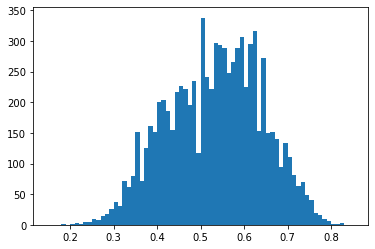

In [7]:
plt.hist(df_odds.implied_prob_h_mid, bins=np.linspace(.15,.85,71));

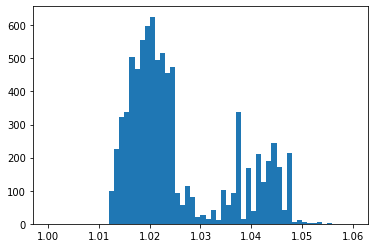

In [8]:
plt.hist(df_odds.implied_prob_h + df_odds.implied_prob_v, bins=np.linspace(1,1.06,61));

## Begin Modeling

In [9]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1980) & (df.season<=2018)]
df_valid = df[(df.season>=2019) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [10]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            # 'OBP_30_h','OBP_30_v',
            # 'SLG_30_h','SLG_30_v',
            # 'game_no_h',
           ]
target = 'home_victory'

In [11]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [12]:
X_train.shape, X_valid.shape, X_test.shape, 

((85954, 4), (3327, 4), (4856, 4))

In [13]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=3)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.689016
[20]	valid_0's binary_logloss: 0.687539
[30]	valid_0's binary_logloss: 0.686314
[40]	valid_0's binary_logloss: 0.685139
[50]	valid_0's binary_logloss: 0.684095
[60]	valid_0's binary_logloss: 0.683286
[70]	valid_0's binary_logloss: 0.682619
[80]	valid_0's binary_logloss: 0.682139
[90]	valid_0's binary_logloss: 0.681792
[100]	valid_0's binary_logloss: 0.681585
[110]	valid_0's binary_logloss: 0.681362
[120]	valid_0's binary_logloss: 0.681224
[130]	valid_0's binary_logloss: 0.68108
[140]	valid_0's binary_logloss: 0.681012
[150]	valid_0's binary_logloss: 0.680932
[160]	valid_0's binary_logloss: 0.680832
[170]	valid_0's binary_logloss: 0.680693
[180]	valid_0's binary_logloss: 0.680703
[190]	valid_0's binary_logloss: 0.68078
[200]	valid_0's binary_logloss: 0.680797
[210]	valid_0's binary_logloss: 0.680882
[220]	valid_0's binary_logloss: 0.680843
[230]	valid_0's binary_logloss: 0.680933
Early s

LGBMClassifier(learning_rate=0.02, max_depth=3, n_estimators=1000)

In [14]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [15]:
hv_mean = y_train.mean()

In [16]:
lgbm_loss = log_loss(y_test, preds_lgbm)
naive_loss = log_loss(y_test, hv_mean*np.ones(len(y_test)))
lgbm_loss, naive_loss

(0.6828936002673683, 0.6904977947935393)

In [17]:
lv_loss = log_loss(y_test, df_test.implied_prob_h_mid)
lv_loss

0.6674197609198098

In [18]:
(naive_loss - lgbm_loss)/(naive_loss - lv_loss)

0.329499235843791

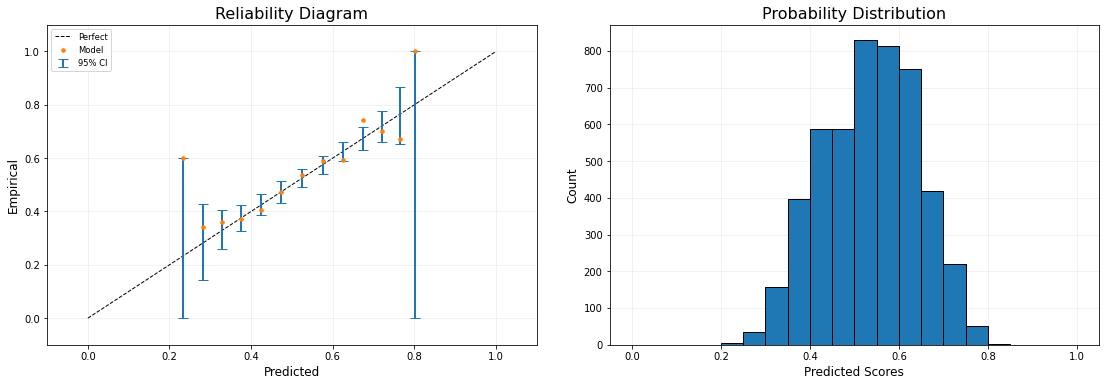

In [19]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, df_test.implied_prob_h_mid, show_histogram=True);

## Analyze discrepancies

In [20]:
test_disc = np.abs(preds_lgbm - df_test.implied_prob_h_mid)

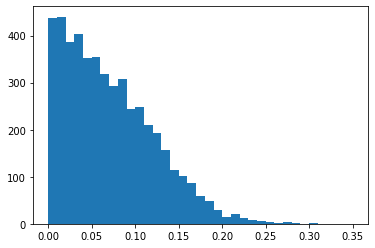

In [21]:
plt.hist(test_disc, np.linspace(0,.35,36));

In [22]:
df_test[test_disc>.25]

,date,dblheader_code,day_of_week,team_v,league_v,game_no_v,team_h,league_h,game_no_h,runs_v,runs_h,outs_total,day_night,completion_info,forfeit_info,protest_info,ballpark_id,attendance,game_minutes,linescore_v,linescore_h,AB_v,H_v,2B_v,3B_v,HR_v,RBI_v,SH_v,SF_v,HBP_v,BB_v,IBB_v,SO_v,SB_v,CS_v,GIDP_v,CI_v,LOB_v,P_num_v,ERind_v,ERteam_v,WP_v,balk_v,PO_v,ASST_v,ERR_v,PB_v,DP_v,TP_v,AB_h,H_h,2B_h,3B_h,HR_h,RBI_h,SH_h,SF_h,HBP_h,BB_h,IBB_h,SO_h,SB_h,CS_h,GIDP_h,CI_h,LOB_h,P_num_h,ERind_h,ERteam_h,WP_h,balk_h,PO_h,ASST_h,ERR_h,PB_h,DP_h,TP_h,ump_HB_id,ump_HB_name,ump_1B_id,ump_1B_name,ump_2B_id,ump_2B_name,ump_3B_id,ump_3B_name,ump_LF_id,ump_LF_name,ump_RF_id,ump_RF_name,mgr_id_v,mgr_name_v,mgr_id_h,mgr_name_h,pitcher_id_w,pitcher_name_w,pitcher_id_l,pitcher_name_l,pitcher_id_s,pitcher_name_s,GWRBI_id,GWRBI_name,pitcher_start_id_v,pitcher_start_name_v,pitcher_start_id_h,pitcher_start_name_h,batter1_name_v,batter1_id_v,batter1_pos_v,batter2_name_v,batter2_id_v,batter2_pos_v,batter3_name_v,batter3_id_v,batter3_pos_v,batter4_name_v,batter4_id_v,batter4_pos_v,batter5_name_v,batter5_id_v,batter5_pos_v,batter6_name_v,batter6_id_v,batter6_pos_v,batter7_name_v,batter7_id_v,batter7_pos_v,batter8_name_v,batter8_id_v,batter8_pos_v,batter9_name_v,batter9_id_v,batter9_pos_v,batter1_name_h,batter1_id_h,batter1_pos_h,batter2_name_h,batter2_id_h,batter2_pos_h,batter3_name_h,batter3_id_h,batter3_pos_h,batter4_name_h,batter4_id_h,batter4_pos_h,batter5_name_h,batter5_id_h,batter5_pos_h,batter6_name_h,batter6_id_h,batter6_pos_h,batter7_name_h,batter7_id_h,batter7_pos_h,batter8_name_h,batter8_id_h,batter8_pos_h,batter9_name_h,batter9_id_h,batter9_pos_h,misc_info,acqui_info,season,run_diff,home_victory,run_total,date_dblhead,BATAVG_162_h,BATAVG_162_v,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,OBS_162_h,OBS_162_v,SB_162_h,SB_162_v,CS_162_h,CS_162_v,ERR_162_h,ERR_162_v,BATAVG_30_h,BATAVG_30_v,OBP_30_h,OBP_30_v,SLG_30_h,SLG_30_v,OBS_30_h,OBS_30_v,SB_30_h,SB_30_v,CS_30_h,CS_30_v,ERR_30_h,ERR_30_v,implied_prob_h,implied_prob_v,implied_prob_h_mid,over_under_line,over_under_result
93402,20210901,0,Wed,NYA,AL,133,ANA,AL,134,4,1,54,D,NaN,NaN,NaN,ANA01,28753.0,170,002100010,000001000,33,8,1,0,1,4,0,0,1,3,0,7,0,1,1,0,6,3,1,1,0,0,27,8,0,0,0,0,31,4,2,0,0,1,0,0,0,0,0,16,0,0,0,0,3,5,4,4,0,0,27,13,0,0,2,0,valej901,Junior Valentine,holbs901,Sam Holbrook,muchm901,Mike Muchlinski,wolfj901,Jim Wolf,NaN,(none),NaN,(none),boona001,Aaron Boone,maddj801,Joe Maddon,coleg001,Gerrit Cole,naugp001,Packy Naughton,chapa001,Aroldis Chapman,voitl001,Luke Voit,coleg001,Gerrit Cole,naugp001,Packy Naughton,lemad001,DJ LeMahieu,4,rizza001,Anthony Rizzo,3,judga001,Aaron Judge,9,voitl001,Luke Voit,10,gallj002,Joey Gallo,7,higak001,Kyle Higashioka,2,odorr001,Rougned Odor,5,velaa001,Andrew Velazquez,6,gardb001,Brett Gardner,8,fletd002,David Fletcher,4,ohtas001,Shohei Ohtani,10,gossp001,Phil Gosselin,5,walsj001,Jared Walsh,3,uptoj001,Justin Upton,7,marsb002,Brandon Marsh,8,stasm001,Max Stassi,2,adelj001,Jo Adell,9,mayfj001,Jack Mayfield,6,NaN,Y,2021,-3,0,5,202109010,0.253074,0.240195,0.314006,0.325054,0.424482,0.409645,0.738488,0.734700,75.0,70.0,27.0,17.0,94.0,110.0,0.226950,0.250501,0.292208,0.329148,0.355623,0.434870,0.647831,0.764018,23.0,20.0,8.0,4.0,11.0,20.0,0.294118,0.736842,0.278638,8.5,U
94764,20220614,0,Tue,ATL,NL,63,WAS,NL,64,10,4,54,N,NaN,NaN,NaN,WAS11,24490.0,194,115002001,003001000,39,13,1,0,5,9,0,1,1,4,0,8,0,0,0,0,8,3,4,4,1,0,27,7,0,0,0,0,33,7,1,0,0,3,0,1,0,1,0,8,0,0,0,0,4,4,10,10,1,0,27,6,0,0,0,0,wolcq901,Quinn Wolcott,porta901,Alan Porter,dejer901,Ramon De Jesus,becka901,Adam Beck,NaN,(none),NaN,(none),snitb801,Brian Snitker,martd002,Dave Martinez,friem001,Max Fried,tetrj001,Jackson Tetreault,stepj002,Jackson Stephens,swand001,Dansby Swanson,friem001,Max Fried,tetrj001,Jackson Tetreault,acunr001,Ronald Acuna,9,swand001,Dansby Swanson,6,rilea001,Austin Riley,5,olsom001,Matt Olson,3,darnt001,Travis d'Arnaud,2,ozunm001,Marcell Ozuna,10,duvaa001,Adam Duvall,7,arcio002,Orlando Arcia,4

In [23]:
# These are the pitchers that were favored in these games
[row[1]['pitcher_start_name_h']  if row[1]['implied_prob_h_mid']>.5 
 else row[1]['pitcher_start_name_v'] 
 for row in df_test[test_disc>.25].iterrows() ]

['Gerrit Cole',
 'Max Fried',
 'Spencer Strider',
 'Jacob deGrom',
 'Chris Bassitt',
 'Mike Clevinger',
 'Yu Darvish',
 'Blake Snell',
 'Yu Darvish',
 'Joe Musgrove',
 'Jacob deGrom',
 'Jacob deGrom']

In [24]:
# These are the underdog pitchers in these games
[row[1]['pitcher_start_name_h']  if row[1]['implied_prob_h_mid']<.5 
 else row[1]['pitcher_start_name_v'] for row in df_test[test_disc>.25].iterrows() ]

['Packy Naughton',
 'Jackson Tetreault',
 'Erasmo Ramirez',
 'Cory Abbott',
 'Anibal Sanchez',
 'Cory Abbott',
 'Anibal Sanchez',
 'Paolo Espino',
 'Anibal Sanchez',
 'Josiah Gray',
 'Ryan Feltner',
 'Johan Oviedo']

In [25]:
pd.crosstab(df_test.home_victory[test_disc>.2], 
            np.round(df_test.implied_prob_h_mid[test_disc>.2], decimals=1))

implied_prob_h_mid,0.2,0.3,0.4,0.7,0.8
home_victory,,,,,
0,2,30,5,2,6
1,3,3,3,11,7


In [26]:
pd.crosstab(df_test.home_victory[test_disc>.2], 
            np.round(preds_lgbm[test_disc>.2], decimals=1))

col_0,0.5,0.6
home_victory,,
0,31,14
1,16,11


## Analysis
 - LV odds are "better" than our current model
 - Largest discrepancies appear when we have a strong pitcher vs a weak pitcher
 - LV probs seem to be "right" in those cases
 - CONCLUSION: Need to factor in the starting pitcher to improve our model!

## Approach
- Get game level data for each pitcher
- Compute statistics based on recent performance of that pitcher
- Augment main dataframe to include these statistics for each game (as would be known prior to the game)
- Build model with these additional features